Chapter 15 Synthetic Control
Codebook for dataset

Context : 
In 2024 June, An e-commerce company specializing in automotive parts decided to extend the estimated delivery time for their bumper cover product line by one day to improve the accuracy of their delivery forecasts. This decision was made in response to numerous complaints about late deliveries. However, the executives noticed a decline in conversion rates, attributing it to customers being deterred by the longer estimated shipping times.

parts-1 is bumper cover.

1. What is Synthetic Control? Please explain high level.
   - Instead of finding similar untreated observations to the treated, we use multiple untreated units which becomes an effective synthetic control. We use other groups as features and time as observations and make the target as the treatment group. This will predict the target group and we use this as potential outcome without treatment.
2. What is unit in the above dataset?
    - Unit is other parts. 

3. Plot line graph. The mean of other parts and treated parts over months. (check below)
    - By exploring the graph below, it shows that, after june, the decline trend became deeper and the added one day shipping caused much higher acceleration of the conversion decline.
4. Perform regression to get synthetic control for part 1 and plot it to compare.
    - The synthetic control trend shows that the conversion is above the bumper cover after september and the intervention which was to increase the estimated shipping by one day does seem to affect the conversion. However, it might be overfitted to the dataset because it shows the straight line even after september.
5. Apply interpolation (sum of all the weights to 1) and do #4.
   - After optimize the error, the synthetic control has an obvious pattern that adding shipping day one affected the conversion rate because it has less decline than bumper cover.
6. Smooth the noises of variance by setting a threshold for pre-intervention error and compare the noise before and after
   
7. Please determine the effect at the end of the year and check the statistical significance.
    

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")
parts = pd.read_csv('parts_example.csv')
parts.head()

,parts,months,conversion
0,1,1,5.0
1,2,1,4.8
2,3,1,4.7
3,4,1,4.6
4,5,1,4.5


In [2]:
parts['bumper_cover'] = parts['parts']==1
parts['shipping_day_1'] = parts['months']>=6

In [3]:
print(parts['conversion'].min())
print(parts['conversion'].max())

1.5
5.0


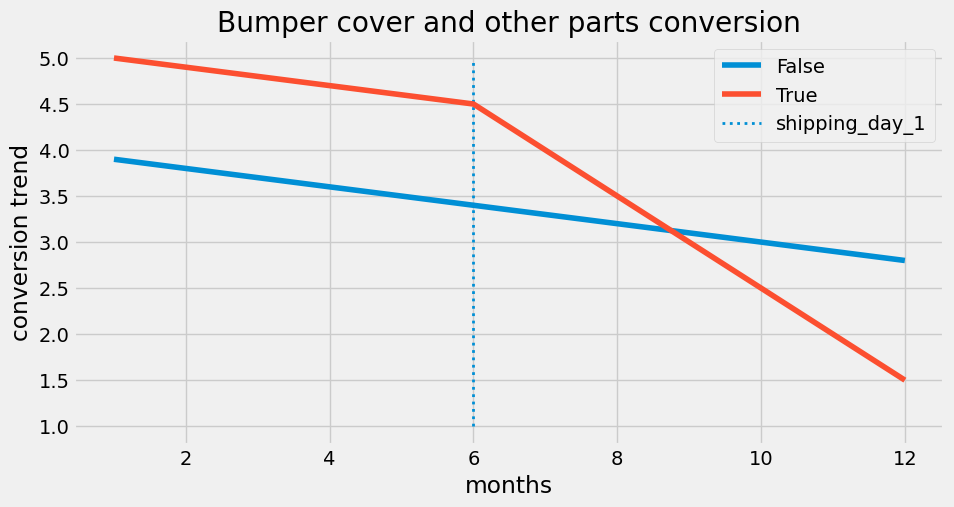

In [4]:
#3. Plot line graph. The mean of other parts and treated parts over months.
ax = plt.subplot(1, 1, 1)

(parts
 .assign(california = np.where(parts["bumper_cover"], "bumper_cover", "Other parts"))
 .groupby(["months", "bumper_cover"])
 ["conversion"]
 .mean()
 .reset_index()
 .pivot("months", "bumper_cover", "conversion")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=6, ymin=1, ymax=5, linestyle=":", lw=2, label="shipping_day_1")
plt.ylabel("conversion trend")
plt.title("Bumper cover and other parts conversion")
plt.legend();  

In [5]:
# 4. Perform regression to get synthetic control for part 1 and plot it to compare.
pivot_parts = parts.pivot_table(index = 'months',columns='parts',values='conversion',aggfunc='sum')

pivot_parts = pivot_parts.reset_index(drop=True)
pivot_parts

parts,1,2,3,...,18,19,20
0,5.0,4.8,4.7,...,3.2,3.1,3.0
1,4.9,4.7,4.6,...,3.1,3.0,2.9
2,4.8,4.6,4.5,...,3.0,2.9,2.8
3,4.7,4.5,4.4,...,2.9,2.8,2.7
4,4.6,4.4,4.3,...,2.8,2.7,2.6
5,4.5,4.3,4.2,...,2.7,2.6,2.5
6,4.0,4.2,4.1,...,2.6,2.5,2.4
7,3.5,4.1,4.0,...,2.5,2.4,2.3
8,3.0,4.0,3.9,...,2.4,2.3,2.2
9,2.5,3.9,3.8,...,2.3,2.2,2.1


In [6]:
y = pivot_parts[1]
X = pivot_parts.drop(columns=1).values

from sklearn.linear_model import LinearRegression
m1 = LinearRegression(fit_intercept=False).fit(X, y)
weights_lr = m1.coef_
weights_lr.round(3)

array([-0.957, -0.831, -0.706, -0.581, -0.455, -0.33 , -0.205, -0.079,
        0.046,  0.171,  0.296,  0.422,  0.547,  0.672,  0.798,  0.923,
        1.048,  1.174,  1.299])

In [7]:
m1.predict(
    (parts.loc[parts['parts']!=1,:]
                  .pivot(index='months', columns="parts")["conversion"]
                  .values)
)

array([5.53846154, 5.21328671, 4.88811189, 4.56293706, 4.23776224,
       3.91258741, 3.58741259, 3.26223776, 2.93706294, 2.61188811,
       2.28671329, 1.96153846])

In [8]:
bumper_synth_lr = (parts.loc[parts['parts']!=1,:]
                  .pivot(index='months', columns="parts")["conversion"]
                  .values.dot(weights_lr))
bumper_synth_lr

array([5.53846154, 5.21328671, 4.88811189, 4.56293706, 4.23776224,
       3.91258741, 3.58741259, 3.26223776, 2.93706294, 2.61188811,
       2.28671329, 1.96153846])

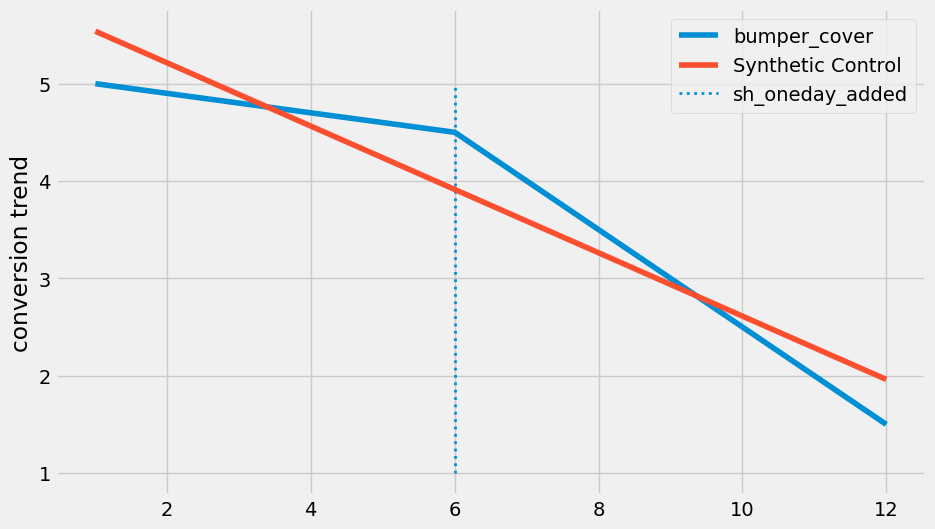

In [9]:
plt.figure(figsize=(10,6))
plt.plot(parts.query("bumper_cover")["months"], parts.query("bumper_cover")["conversion"], label="bumper_cover")
plt.plot(parts.query("bumper_cover")["months"], bumper_synth_lr, label="Synthetic Control")
plt.vlines(x=6, ymin=1, ymax=5, linestyle=":", lw=2, label="sh_oneday_added")
plt.ylabel("conversion trend")
plt.legend();

In [10]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))
lambda x: np.sum(x) - 1
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights
parts_weights = get_w(X, y)
print("Sum:", parts_weights.sum())
np.round(parts_weights, 4)

Sum: 1.0


array([0.174 , 0.1503, 0.1266, 0.1029, 0.0792, 0.0555, 0.0318, 0.0233,
       0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233, 0.0233,
       0.0233, 0.0233, 0.0233])

In [31]:
parts_synth=parts.query("~bumper_cover").pivot(index='months', columns="parts",values='conversion').dot(parts_weights)

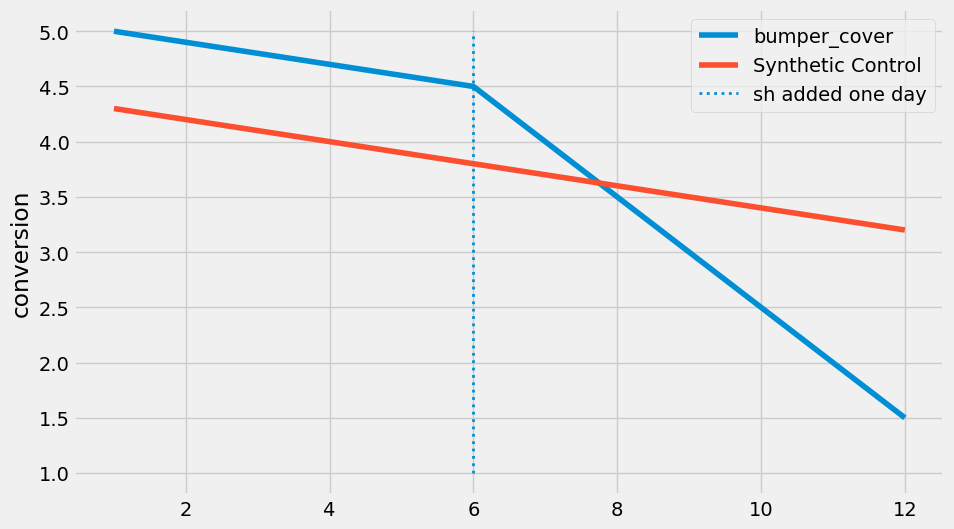

In [33]:
plt.figure(figsize=(10,6))
plt.plot(parts.query("bumper_cover")["months"], parts.query("bumper_cover")["conversion"], label="bumper_cover")
plt.plot(parts.query("bumper_cover")["months"], parts_synth, label="Synthetic Control")
plt.vlines(x=6, ymin=1, ymax=5, linestyle=":", lw=2, label="sh added one day")
plt.ylabel("conversion")
plt.legend();

In [41]:
parts_synth
parts.query("bumper_cover")["conversion"].to_list() - parts_synth

months
1     0.699596
2     0.699596
3     0.699596
4     0.699596
5     0.699596
6     0.699596
7     0.299596
8    -0.100404
9    -0.500404
10   -0.900404
11   -1.300404
12   -1.700404
dtype: float64

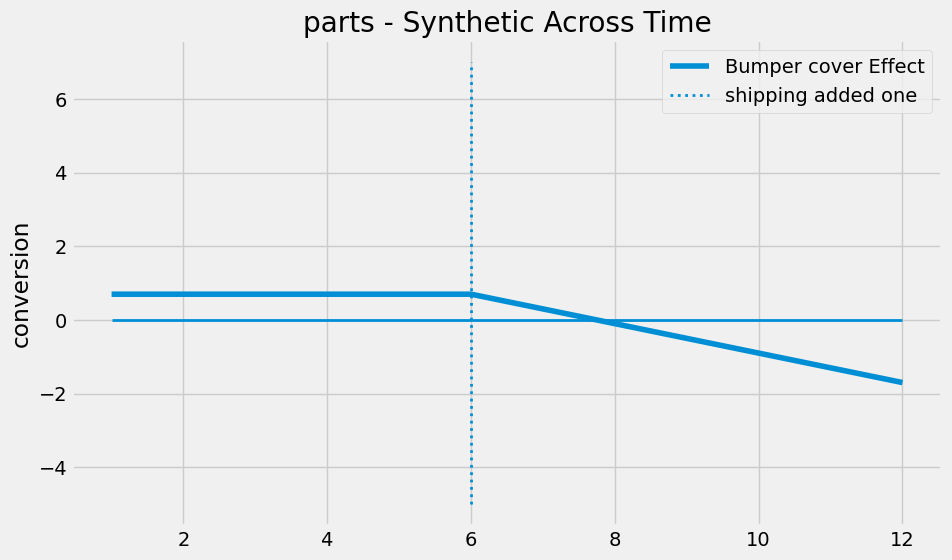

In [46]:
plt.figure(figsize=(10,6))

plt.plot(parts.query("bumper_cover")["months"], parts.query("bumper_cover")["conversion"].to_list() - parts_synth,
         label="Bumper cover Effect")
plt.vlines(x=6, ymin=-5, ymax=7, linestyle=":", lw=2, label="shipping added one")
plt.hlines(y=0, xmin=1, xmax=12, lw=2)
plt.title("parts - Synthetic Across Time")
plt.ylabel("conversion")
plt.legend();

In [50]:
def synthetic_control(parts: int, data: pd.DataFrame) -> np.array:
    
    features = ["conversion"]
    
    inverted = (data.query("~shipping_day_1")
                .pivot(index='parts', columns="months")[features]
                .T)
    
    y = inverted[parts].values # treated
    X = inverted.drop(columns=parts).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(parts=={parts})")
                 .pivot(index='months', columns="parts")["conversion"]
                 .values.dot(weights))

    return (data
            .query(f"parts=={parts}")[["months", "months", "conversion", "shipping_day_1"]]
            .assign(synthetic=synthetic))
synthetic_control(1, parts).head()

,months,months,conversion,shipping_day_1,synthetic
0,1,1,5.0,False,4.8
20,2,2,4.9,False,4.7
40,3,3,4.8,False,4.6
60,4,4,4.7,False,4.5
80,5,5,4.6,False,4.4


In [69]:
from joblib import Parallel, delayed

control_pool = parts["parts"].unique()

parallel_fn = delayed(partial(synthetic_control, data=parts))

synthetic_parts = Parallel(n_jobs=1)(parallel_fn(part) for part in control_pool)

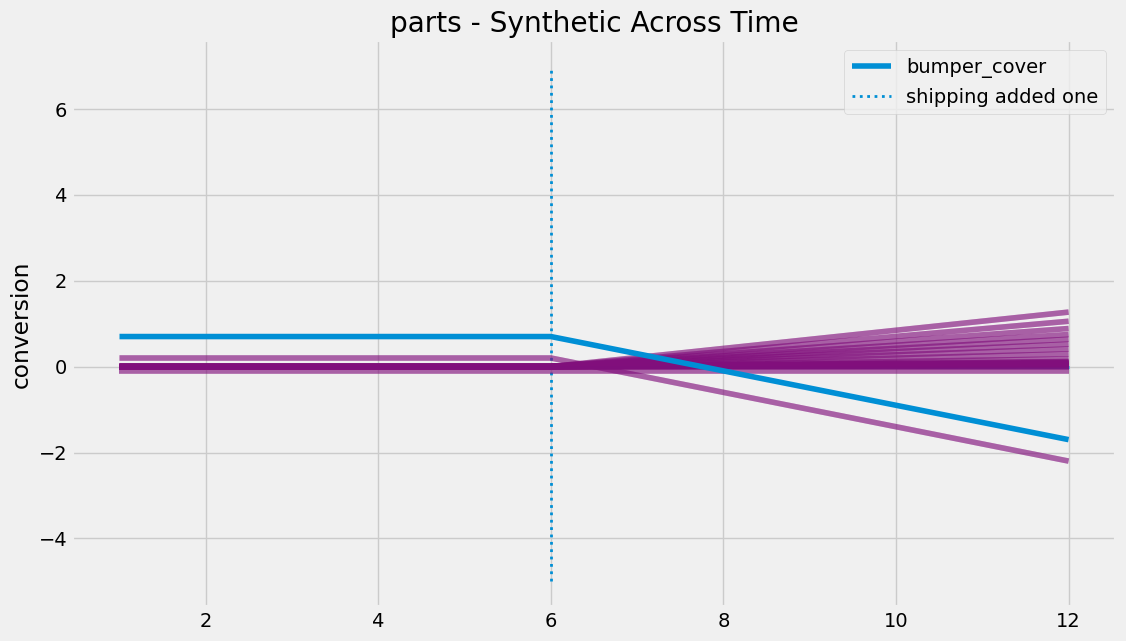

In [70]:
plt.figure(figsize=(12,7))
for part in synthetic_parts:
    plt.plot(part["months"], part["conversion"] - part["synthetic"], color="C5",alpha=0.4)

plt.plot(parts.query("bumper_cover")["months"], parts.query("bumper_cover")["conversion"].to_list() - parts_synth,
        label="bumper_cover");

plt.vlines(x=6, ymin=-5, ymax=7, linestyle=":", lw=2, label="shipping added one")
plt.hlines(y=0, xmin=1, xmax=12, lw=2)
plt.title("parts - Synthetic Across Time")
plt.ylabel("conversion")
plt.legend();

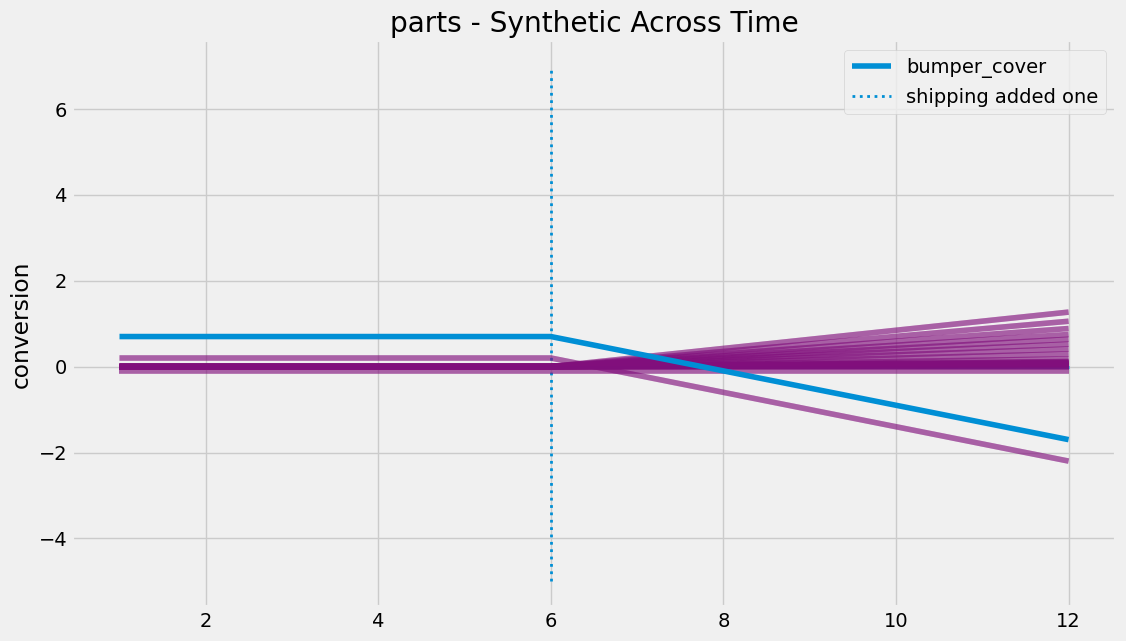

In [94]:
def pre_treatment_error(part):
    pre_treat_error = (part.query("~shipping_day_1")["conversion"] 
                       - part.query("~shipping_day_1")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for part in synthetic_parts:
    
    # remove units with mean error above 10.
    if pre_treatment_error(part) < 5:
        plt.plot(part["months"], part["conversion"] - part["synthetic"], color="C5",alpha=0.4)

plt.plot(parts.query("bumper_cover")["months"], parts.query("bumper_cover")["conversion"].to_list() - parts_synth,
        label="bumper_cover");

plt.vlines(x=6, ymin=-5, ymax=7, linestyle=":", lw=2, label="shipping added one")
plt.hlines(y=0, xmin=1, xmax=12, lw=2)
plt.title("parts - Synthetic Across Time")
plt.ylabel("conversion")
plt.legend();

In [95]:
calif_number = 3

effects = [part.query("months==12").iloc[0]["conversion"] - part.query("months==12").iloc[0]["synthetic"]
           for part in synthetic_parts
           if pre_treatment_error(part) < 1.5] # filter out noise

part_effect = parts.query("bumper_cover & months==12").iloc[0]["conversion"] - parts_synth[12]

print("California Treatment Effect for the Year 2000:", part_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -1.7004038173369063


array([-2.20000000e+00,  1.26862923e+00,  1.05559052e+00,  8.86498331e-01,
        7.47490892e-01,  6.36381484e-01,  5.24008571e-01,  4.10350254e-01,
        2.95384391e-01,  1.79088826e-01,  1.17790950e-01,  1.02438797e-01,
        8.72727457e-02,  7.22888526e-02,  5.74842432e-02,  4.28571303e-02,
        2.97592821e-02,  1.41175799e-02,  1.54346697e-07, -1.00000000e-01])

In [88]:
np.mean(np.array(effects) < np.array(part_effect))

0.05

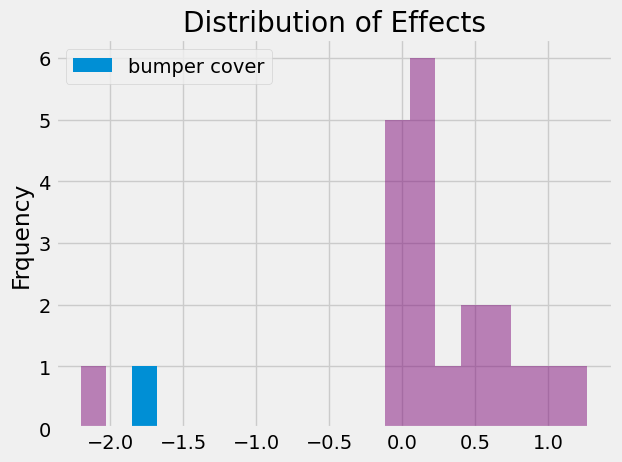

In [89]:
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([part_effect], bins=bins, color="C0", label="bumper cover")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();

Chapter 16 Regression Discontinuity Design

Context : 
Sheepskin

1. What is regression discontinuity? Tell us the purpose.
   - When the two potential outcomes function totally differently by a switch there is a discontinuity and to regression in both before and after to understand the difference.
2. What is R in our dataset?
   - minimum score
3. Draw a scatter plot and center the threshold as 0.
   - The dataset is already centered.
4. What makes it close to randomized trial in our data set with RDD?
   - minscore close to the lowest far from the threshold does not mean the person cannot receive the hsd and their earnings are depending on their life after receiving the highschool deploma. Even with higher score does not get the deploma anyway.
5. What RDD did you use and what is the effect using RDD?
   - Sharp RDD with wald since there is a biase near 0.
   - 151.39
6. Why do we need kernel weighting in our problem? and compare with 5.
   - Kernel weighting is to give more weights near the threshold. 
7. Check sheepskin effect and perform McCrary Test.
   - There is no sheepskin since the prediction trend is very straightforward.
   - For our example, for those who is nearly lower the threshold, cheating/improving on system of the exam rather than their knowledge level for the subject may result in receiving the diploma. Since there is no spikes near the threshold, it means there is not many of people cheating or related entities to just go over the threshold.
9. Write a summary of your final result.
   - The coef of threshold about 151.39 shows that earning education helps for higher income. H The p value for the coef of threshold is greater than 0.05, so it is statistically significant. However, the coef is positive and our data set indicates that there is a positive 

In [97]:
sheep = pd.read_csv('sheepskin2.csv')

sheep.head()

,minscore,person_years,avgearnings,receivehsd,n
0,-30.0,24.0,11845.086,0.416667,12
1,-29.0,104.0,9205.679,0.387097,31
2,-28.0,146.0,8407.745,0.318182,44
3,-27.0,137.0,11114.087,0.377778,45
4,-26.0,227.0,10814.624,0.306667,75


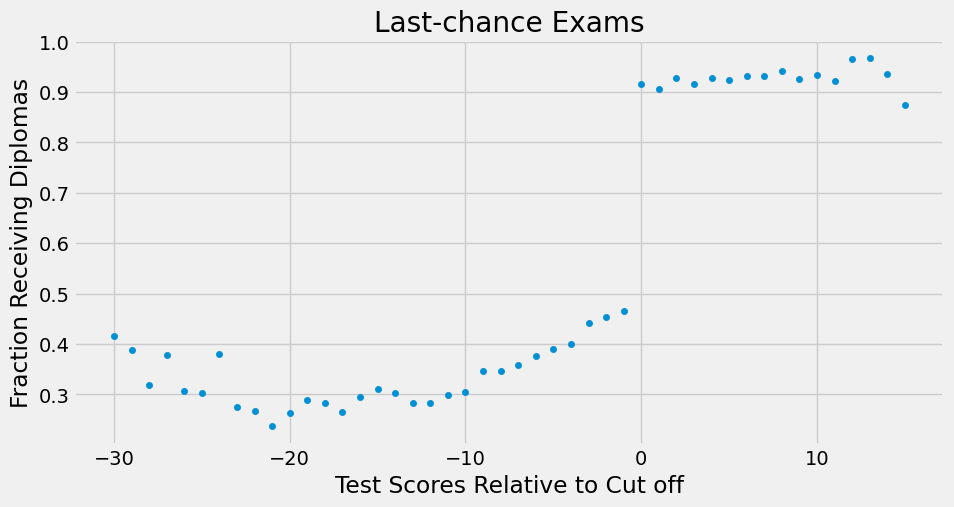

In [98]:
#3. Draw a scatter plot and center the threshold as 0.
sheep.plot.scatter(x="minscore", y="receivehsd", figsize=(10,5))
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Fraction Receiving Diplomas")
plt.title("Last-chance Exams");

In [102]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

In [103]:
sheep_rdd = sheep.assign(threshold=(sheep["minscore"]>0).astype(int))
model = smf.wls("avgearnings~minscore*threshold",
                sheep_rdd,
                weights=kernel(sheep_rdd["minscore"], c=0, h=15)*sheep_rdd["n"]).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.374e+04,80.872,169.901,0.000,1.36e+04,1.39e+04
minscore,152.3156,15.840,9.616,0.000,120.349,184.282
threshold,151.3978,140.837,1.075,0.289,-132.823,435.619
minscore:threshold,47.5434,29.295,1.623,0.112,-11.576,106.663


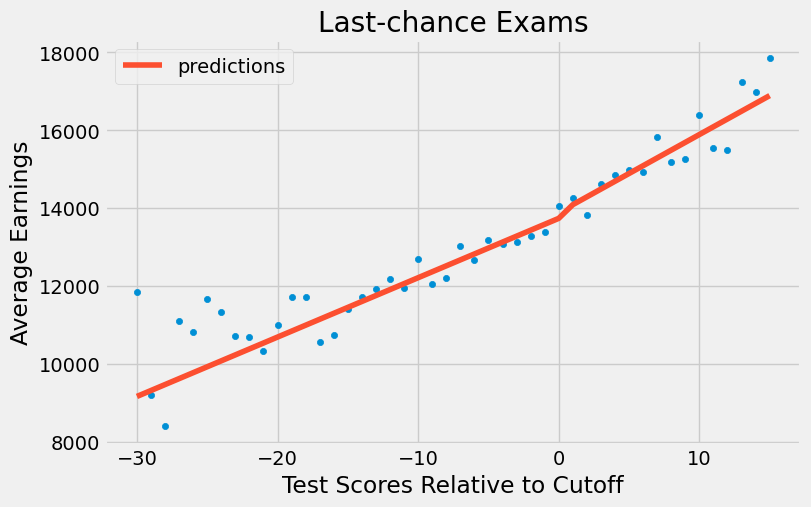

In [104]:
ax = sheep.plot.scatter(x="minscore", y="avgearnings", color="C0")
sheep.assign(predictions=model.fittedvalues).plot(x="minscore", y="predictions", ax=ax, color="C1", figsize=(8,5))
plt.xlabel("Test Scores Relative to Cutoff")
plt.ylabel("Average Earnings")
plt.title("Last-chance Exams");

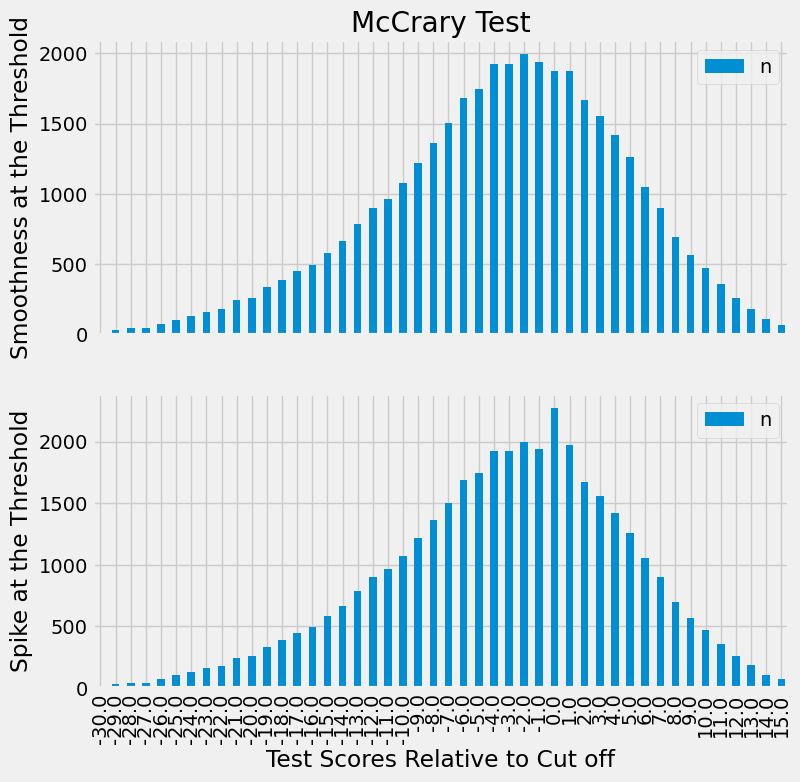

In [100]:
plt.figure(figsize=(8,8))

ax = plt.subplot(2,1,1)
sheep.plot.bar(x="minscore", y="n", ax=ax)
plt.title("McCrary Test")
plt.ylabel("Smoothness at the Threshold")

ax = plt.subplot(2,1,2, sharex=ax)
sheep.replace({1877:1977, 1874:2277}).plot.bar(x="minscore", y="n", ax=ax)
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Spike at the Threshold");